In [50]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.ml.feature import VectorAssembler, StringIndexer, Binarizer, Bucketizer
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import GBTClassifier, GBTClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import Window
from pyspark.sql.functions import to_date, col, weekday, max, dayofweek, split, count_distinct

In [16]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("lab 2 Test")
    conf.setMaster("yarn")
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "2")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")
    conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}/warehouse")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

In [17]:
conf = create_spark_configuration()

In [18]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

25/01/18 07:18:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/01/18 07:18:12 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.
25/01/18 07:18:32 WARN Client: Same path resource file:///home/user1/.ivy2/jars/org.apache.iceberg_iceberg-spark-runtime-3.5_2.12-1.6.0.jar added multiple times to distributed cache.


In [19]:
database_name = "lopin_database2"

In [20]:
spark.catalog.setCurrentDatabase(database_name)

In [21]:
df = spark.table("sobd_lab2")

In [22]:
df.printSchema()

root
 |-- user_session: string (nullable = true)
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: string (nullable = true)
 |-- event_date: date (nullable = true)
 |-- is_purchased: integer (nullable = true)
 |-- event_weekday: integer (nullable = true)
 |-- activity_count: long (nullable = true)



In [23]:
df.count()

546600

In [24]:
def stratified_train_test_split(data: DataFrame, 
                                label_col: str,
                                ratio: float) -> tuple[DataFrame, DataFrame]:
    """
    Разделяет DataFrame на тренировочный и тестовый наборы с учетом стратификации.

    Args:
        data: Исходный DataFrame.
        label_col: Название столбца с меткой.
        ratio: Пропорция разделения данных.

    Returns:
        tuple[DataFrame, DataFrame]: Кортеж из тренировочного и тестового DataFrame.
    """
    # Проверяем корректность доли разделения
    assert (isinstance(ratio, float) and (0.0 <= ratio <= 1.0))
    
    # Формируем разделение для положительных и отрицательных объектов раздельно
    train_df_pos, test_df_pos = (data
                                 .filter(F.col(label_col) == 1)
                                 .randomSplit([ratio, 1 - ratio]))
    train_df_neg, test_df_neg = (data
                                 .filter(F.col(label_col) == 0)
                                 .randomSplit([ratio, 1 - ratio]))
    
    # Объединяем датафреймы
    return (train_df_pos.union(train_df_neg),
            test_df_pos.union(test_df_neg))

In [25]:
train_df, test_df = stratified_train_test_split(df, "is_purchased", 0.8)

In [26]:
train_df = train_df.cache()
test_df = test_df.cache()

print(f"Train dataset size: {train_df.count()}")
print(f"Test  dataset size: {test_df.count()}")

Train dataset size: 437150


Test  dataset size: 109450


In [27]:
train_df.groupBy("is_purchased").count().show()

+------------+------+
|is_purchased| count|
+------------+------+
|           1|219088|
|           0|218062|
+------------+------+



In [43]:
categorical_features = ["category_code", "brand", "event_weekday"]
numeric_features = ["activity_count", "price"]

In [54]:
df.select("category_code").distinct().count()

89

In [55]:
df.select("brand").distinct().count()

369

In [56]:
df.select("event_weekday").distinct().count()

7

In [58]:
def create_pipeline(categorical_features: list[str], numeric_features: list[str], 
                    label_col: str, max_iter: int) -> Pipeline:
    """
    Создает конвейер для обработки данных и обучения модели градиентного бустинга.

    Args:
        categorical_features: Список категориальных признаков.
        numeric_features: Список количественных признаков.
        binary_features: Список бинарных признаков.
        binarized_col: Название бинаризуемого признака.
        threshold: Порог бинаризации.
        label_col: Название столбца с меткой.
        max_iter: Максимальное количество итераций для модели.

    Returns:
        Pipeline: Конвейер для обработки данных и обучения модели.
    """
    # Формируем названия колонок для преобразованных признаков
    indexed_categorical_features = [f"{feature}_index" for feature in categorical_features]
    
    # Выполняем преобразования данных
    string_indexer = StringIndexer(inputCols=categorical_features,
                                   outputCols=indexed_categorical_features,
                                   handleInvalid="keep")
    vector_all_assembler = VectorAssembler(
        inputCols=(indexed_categorical_features  +
                   numeric_features),
        outputCol="features"
    )

    # Создаем модель линейной регрессии
    gbt_classifier = GBTClassifier(featuresCol="features",
                                   labelCol=label_col,
                                   predictionCol="prediction",
                                   maxIter=max_iter,
                                   maxBins=370)

    # Создаем конвейер
    pipeline = Pipeline(stages=[
        string_indexer, vector_all_assembler, gbt_classifier
    ])

    return pipeline

In [59]:
pipeline = create_pipeline(categorical_features=categorical_features,
                           numeric_features=numeric_features,
                           label_col="is_purchased",
                           max_iter=32)

In [60]:
param_grid = ParamGridBuilder() \
    .addGrid(pipeline.getStages()[-1].maxDepth, [5]) \
    .addGrid(pipeline.getStages()[-1].stepSize, [0.01]) \
    .build()

In [61]:
cv_evaluator = BinaryClassificationEvaluator(labelCol="is_purchased")

In [62]:
cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=cv_evaluator,
                                 numFolds=5)

In [63]:
cv_model = cross_validator.fit(train_df)

25/01/18 08:02:13 WARN DAGScheduler: Broadcasting large task binary with size 1001.3 KiB
25/01/18 08:02:14 WARN DAGScheduler: Broadcasting large task binary with size 1006.4 KiB
25/01/18 08:02:15 WARN DAGScheduler: Broadcasting large task binary with size 1012.6 KiB
25/01/18 08:02:16 WARN DAGScheduler: Broadcasting large task binary with size 1013.1 KiB
25/01/18 08:02:16 WARN DAGScheduler: Broadcasting large task binary with size 1017.6 KiB
25/01/18 08:02:17 WARN DAGScheduler: Broadcasting large task binary with size 1023.9 KiB
25/01/18 08:02:18 WARN DAGScheduler: Broadcasting large task binary with size 1030.5 KiB
25/01/18 08:02:19 WARN DAGScheduler: Broadcasting large task binary with size 1038.3 KiB
25/01/18 08:02:20 WARN DAGScheduler: Broadcasting large task binary with size 1038.7 KiB
25/01/18 08:02:20 WARN DAGScheduler: Broadcasting large task binary with size 1043.2 KiB
25/01/18 08:02:21 WARN DAGScheduler: Broadcasting large task binary with size 1052.9 KiB
25/01/18 08:02:22 WAR

In [64]:
def get_best_model_params(cv_model: CrossValidatorModel) -> dict[str, float]:
    """
    Получает параметры лучшей модели из объекта CrossValidatorModel.

    Args:
        cv_model: Объект CrossValidatorModel, содержащий лучшую модель.

    Returns:
        Dict[str, float]: Параметры лучшей модели.
    """
    best_model = cv_model.bestModel
    best_params = {
        "maxDepth": best_model.stages[-1].getMaxDepth(),
        "stepSize": best_model.stages[-1].getStepSize(),
        "maxIter": best_model.stages[-1].getMaxIter()
    }
    return best_params

In [65]:
for key, value in get_best_model_params(cv_model=cv_model).items():
    print(f"{key}: {value}")

maxDepth: 5
stepSize: 0.01
maxIter: 32


In [67]:
# Получаем датасет предсказаний
test_df_predictions = cv_model.transform(test_df)

# Извлекаем список колонок, устанавливаем цену на последнее место
right_columns_order = test_df_predictions.columns
right_columns_order.remove("is_purchased")
right_columns_order.append("is_purchased")

# Изменяем последовательность колонок и выводим датафрейм
test_df_predictions = test_df_predictions.select(*right_columns_order)
test_df_predictions.show()

25/01/18 08:16:10 WARN DAGScheduler: Broadcasting large task binary with size 1038.5 KiB


+--------------------+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+----------+-------------+--------------+-------------------+-----------+-------------------+--------------------+--------------------+--------------------+----------+------------+
|        user_session|          event_time|event_type|product_id|        category_id|       category_code|  brand|  price|  user_id|event_date|event_weekday|activity_count|category_code_index|brand_index|event_weekday_index|            features|       rawPrediction|         probability|prediction|is_purchased|
+--------------------+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+----------+-------------+--------------+-------------------+-----------+-------------------+--------------------+--------------------+--------------------+----------+------------+
|0002b07c-85cd-46e...|2019-10-14 09:16:...|      cart|   1004776

In [68]:
def evaluate_model(data: DataFrame, 
                   label_col: str) -> dict[str, float]:
    """
    Оценивает модель с использованием метрик точности, полноты и F1-score.

    Args:
        data: DataFrame, содержащий предсказания и фактические метки.
        label_col: Название колонки с меткой.

    Returns:
        dict[str, float]: Словарь с метриками точности, полноты и F1-score.
    """
    # Вычисляем TP, FP, FN
    tp = data.filter((F.col(label_col) == 1) &
                     (F.col("prediction") == 1)).count()
    fp = data.filter((F.col(label_col) == 0) &
                     (F.col("prediction") == 1)).count()
    fn = data.filter((F.col(label_col) == 1) &
                     (F.col("prediction") == 0)).count()

    # Вычисляем метрики
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * (precision * recall) / (precision + recall)
        if (precision + recall) > 0 else 0)

    # Возвращаем словарь с метриками
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [70]:
metrics = evaluate_model(test_df_predictions, "is_purchased")
print(f"Metrics: {metrics}")

25/01/18 08:17:21 WARN DAGScheduler: Broadcasting large task binary with size 1027.1 KiB
25/01/18 08:17:24 WARN DAGScheduler: Broadcasting large task binary with size 1027.1 KiB
25/01/18 08:17:27 WARN DAGScheduler: Broadcasting large task binary with size 1027.1 KiB


Metrics: {'precision': 0.5862623579755054, 'recall': 0.7247405191441236, 'f1': 0.6481878767609368}


In [71]:
def calculate_auc_roc(model: GBTClassificationModel, 
                      test_data: DataFrame,
                      label_col: str) -> float:
    """
    Рассчитывает значение AUC ROC для модели.

    Args:
        model: Обученная модель классификации.
        test_data: Тестовый набор данных.
        label_col: Название столбца с меткой.

    Returns:
        float: Значение AUC ROC.
    """
    # Получаем прогнозы модели
    predictions = model.transform(test_data)

    # Создаем "оценщик" бинарной классификации
    evaluator = BinaryClassificationEvaluator(
        rawPredictionCol="rawPrediction",
        labelCol=label_col
    )

    # Вычисляем AUC ROC
    auc_roc = evaluator.evaluate(predictions)

    return auc_roc

In [72]:
def prepare_metrics_df(predictions: DataFrame, label_col: str) -> DataFrame:
    """
    Подготавливает DataFrame для расчета FPR, TPR и Precision.

    Args:
        predictions: DataFrame с прогнозами модели.
        label_col: Название столбца с меткой.

    Returns:
        DataFrame: DataFrame с рассчитанными столбцами FPR, TPR и Precision.
    """
    # Формируем датафрейм, содержащий результат предсказания,
    # вероятность предсказания и метку
    metrics_df = (
        predictions
        .select(
            vector_to_array(
                F.col("probability")
            ).getItem(1).alias("probability"),
            
            F.col(label_col).alias("label"),
            F.col("prediction").cast("int").alias("prediction")
        )
    )

    # Сортируем датафрейм по значениям вероятности
    metrics_df = metrics_df.orderBy("probability")

    # Рассчитываем количество положительных и отрицательных классов
    pos_count = metrics_df.filter(metrics_df.label == 1).count()
    neg_count = metrics_df.filter(metrics_df.label == 0).count()

    # Рассчитываем значения FPR и TPR
    window = Window.partitionBy().orderBy(F.desc("probability"))
    metrics_df = (
        metrics_df
        .withColumn("FP_cum", 
                    F.sum(F.when(
                        F.col("label") == 0, 1
                    ).otherwise(0)).over(window))
        .withColumn("TP_cum", F.sum(F.col("label")).over(window))
        .withColumn("FPR", F.col("FP_cum") / neg_count)
        .withColumn("TPR", F.col("TP_cum") / pos_count)
        .withColumn("Precision", 
                    F.col("TP_cum") / (F.col("TP_cum") + F.col("FP_cum")))
    )

    return metrics_df

In [73]:
def bucketize_metrics_df(metrics_df: DataFrame, 
                         num_buckets: int = 1000) -> DataFrame:
    """
    Применяет Bucketizer к DataFrame для уменьшения объёма данных, 
    возвращаемых на драйвер.

    Args:
        metrics_df: DataFrame с рассчитанными столбцами FPR, TPR и Precision.
        num_buckets: Количество бакетов.

    Returns:
        DataFrame: Бакетизированный Dataframe.
    """
    # Определяем границы бакетов
    bucketizer = Bucketizer(
        splits=list(np.linspace(0, 1, num_buckets + 1)),
        inputCol="probability",
        outputCol="bucket"
    )

    # Применяем Bucketizer
    metrics_df = bucketizer.setHandleInvalid("error").transform(metrics_df)

    # Формируем одну точку из каждого бакета
    metrics_df = metrics_df.groupBy("bucket").agg(
        F.avg(F.col("probability")).alias("probability"),
        F.avg(F.col("FPR")).alias("FPR"),
        F.avg(F.col("TPR")).alias("TPR"),
        F.avg(F.col("Precision")).alias("Precision")
    )

    return metrics_df

In [74]:
def calculate_metrics(model: GBTClassificationModel, 
                      test_data: DataFrame,
                      label_col: str) -> pd.DataFrame:
    """
    Рассчитывает значения FPR, TPR и Precision для построения ROC и PR-кривых.

    Args:
        model: Обученная модель классификации.
        test_data: Тестовый набор данных.
        label_col: Название столбца с меткой.

    Returns:
        tuple[float, pd.DataFrame]: Кортеж из значения AUC ROC и DataFrame 
                                    со значениями FPR, TPR и Precision.
    """
    # Получаем прогнозы модели
    predictions = model.transform(test_data)

    # Подготавливаем DataFrame для расчета FPR, TPR и Precision
    metrics_df = prepare_metrics_df(predictions, label_col)

    # Применяем Bucketizer к DataFrame
    metrics_df = bucketize_metrics_df(metrics_df)

    return metrics_df.toPandas()

In [75]:
def plot_roc_pr_curves(pd_data: pd.DataFrame, 
                       auc_roc: float) -> None:
    """
    Визуализирует ROC и PR-кривые, добавляет на график AUC ROC.

    Args:
        pd_data: Pandas DataFrame, содержащий столбцы 
            "FPR", "TPR", "Precision".
        auc_roc: Значение AUC-ROC.

    Returns:
        None
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Построение ROC-кривой
    sns.lineplot(x="FPR", y="TPR", data=pd_data, ax=axes[0])
    sns.lineplot(x=[0, 1], y=[0, 1], 
                 color="gray", linestyle="--", ax=axes[0])
    axes[0].set_xlabel("False Positive Rate (FPR)")
    axes[0].set_ylabel("True Positive Rate (TPR)")
    axes[0].set_title("ROC Curve")
    axes[0].grid()

    # Добавляем значение AUC-ROC в правом нижнем углу графика
    axes[0].text(0.94, 0.06, f'AUC-ROC: {auc_roc:.2f}', 
                 transform=axes[0].transAxes,
                 fontsize=12, verticalalignment='bottom', 
                 horizontalalignment='right',
                 bbox=dict(facecolor='white', 
                           alpha=0.8), zorder=5)

    # Построение PR-кривой
    sns.lineplot(x="TPR", y="Precision", 
                 data=pd_data, ax=axes[1])
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("PR Curve")
    axes[1].grid()

    plt.tight_layout()
    plt.show()

25/01/18 08:26:00 WARN DAGScheduler: Broadcasting large task binary with size 1038.4 KiB
25/01/18 08:26:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/18 08:26:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/18 08:26:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/18 08:26:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/18 08:26:07 WARN DAGScheduler: Broadcasting large task binary with size 1026.7 KiB
25/01/18 08:26:14 WARN DAGScheduler: Broadcasting large task binary with size 1033.0 KiB
25/01/18 08:26:16 WARN WindowExec: No Partition Defined for Window operat

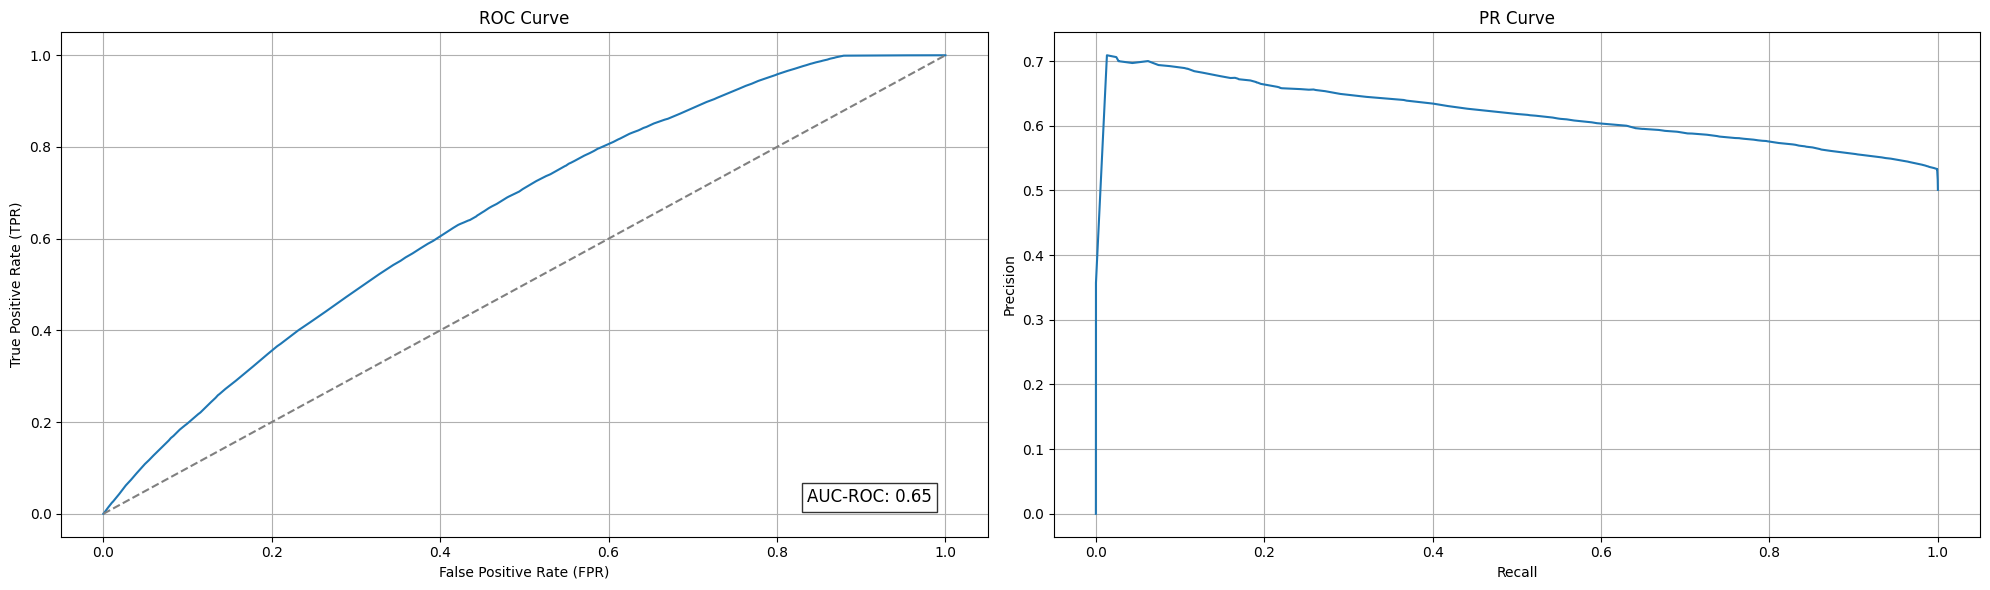

In [76]:
auc_roc = calculate_auc_roc(model=cv_model,
                            test_data=test_df,
                            label_col="is_purchased")
pd_dataframe = calculate_metrics(model=cv_model,
                                 test_data=test_df,
                                 label_col="is_purchased")
plot_roc_pr_curves(pd_dataframe, auc_roc)

In [77]:
threshold_probability = pd_dataframe[pd_dataframe['TPR'] >= 0.60]['probability'].max()
print(f"Вероятность -- граница разделения, при которой TPR не меньше 60%: {threshold_probability:.2f}")

Вероятность -- граница разделения, при которой TPR не меньше 60%: 0.55


In [78]:
cv_model.bestModel.stages[-1].setThresholds([1 - threshold_probability, 
                                             threshold_probability])
test_df_predictions = cv_model.transform(test_df)
metrics = evaluate_model(test_df_predictions, "is_purchased")
print(f"Metrics: {metrics}")

25/01/18 08:27:57 WARN DAGScheduler: Broadcasting large task binary with size 1027.1 KiB
25/01/18 08:28:00 WARN DAGScheduler: Broadcasting large task binary with size 1027.1 KiB
25/01/18 08:28:04 WARN DAGScheduler: Broadcasting large task binary with size 1027.1 KiB


Metrics: {'precision': 0.6008493314147334, 'recall': 0.624578172598092, 'f1': 0.6124840126289052}


In [79]:
spark.stop()